## Variacinis klasifikatorius naudojant PennyLane karkasą

https://pennylane.ai/qml/demos/tutorial_variational_classifier/

https://arxiv.org/abs/1802.06002

https://arxiv.org/abs/1804.00633

In [37]:
!pip3 install pennylane

In [38]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import pandas as pd
from sklearn import datasets, preprocessing

In [39]:
NUM_QUBITS=2
dev = qml.device("default.qubit", wires=NUM_QUBITS)

## Get angles from image data

In [40]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

Layer definition

In [41]:
def layer(W):
    for i in range(NUM_QUBITS):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(NUM_QUBITS - 1):
        qml.CNOT(wires=[j, j + 1])
    if NUM_QUBITS > 2:
        qml.CNOT(wires=[NUM_QUBITS - 1, 0])

# Sluoksnio kvantinės grandinės pavyzdys
Atsižvelgiant į nustatytus svorius yra nustatomi rotacijos operatoriai kiekvienam kubitui prieš ir po CNOT sluoksnio, kuris apjungia visus kubitus

[[-0.14767274 -0.09575167  0.43986384]
 [ 0.26210549  0.25605261 -0.64678242]]


(<Figure size 500x300 with 1 Axes>, <Axes: >)

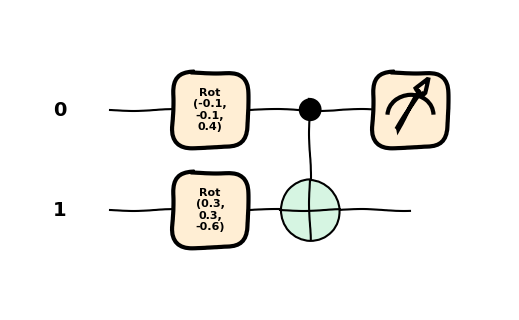

In [42]:
def draw_layer(W):
    for i in range(NUM_QUBITS):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(NUM_QUBITS - 1):
        qml.CNOT(wires=[j, j + 1])
    if NUM_QUBITS > 2:
        qml.CNOT(wires=[NUM_QUBITS - 1, 0])
    return qml.expval(qml.PauliZ(0))


random_weights = 0.4 * np.random.randn(6, 2, 3, requires_grad=True)
print(random_weights[0])
qnode = qml.QNode(draw_layer, dev)
qml.draw_mpl(qnode, decimals=1,style="sketch")(random_weights[0])


## Variational Quantum Classifier prepration

In [43]:
# def statepreparation(x):
#     qml.BasisState(x, wires=[0, 1, 2, 3])

def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias

## Būsenos paruošimas
Iš duomenų gauti kampai yra apdorojami ir paruošiami būsena prieš variacinio klasifikatoriaus sluoksnius

[0.23879026, -0.55107359, 0.55107359, -1.22918084, 1.22918084]


(<Figure size 1200x300 with 1 Axes>, <Axes: >)

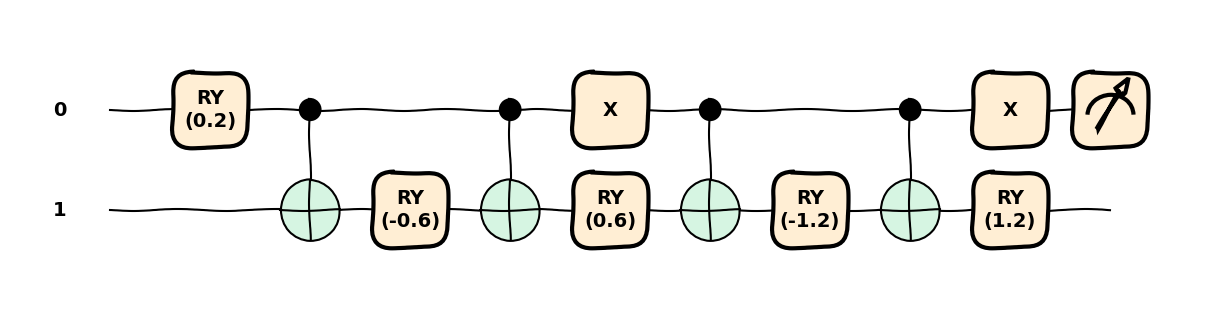

In [44]:
def draw_statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

    return qml.expval(qml.PauliZ(0))
test_angles = [0.23879026, -0.55107359,  0.55107359, -1.22918084,  1.22918084]
print(test_angles)
qnode = qml.QNode(draw_statepreparation, dev)
qml.draw_mpl(qnode, decimals=1,style="sketch")(test_angles)


Visa grandinė

[0.23879026, -0.55107359, 0.55107359, -1.22918084, 1.22918084]


(<Figure size 2400x300 with 1 Axes>, <Axes: >)

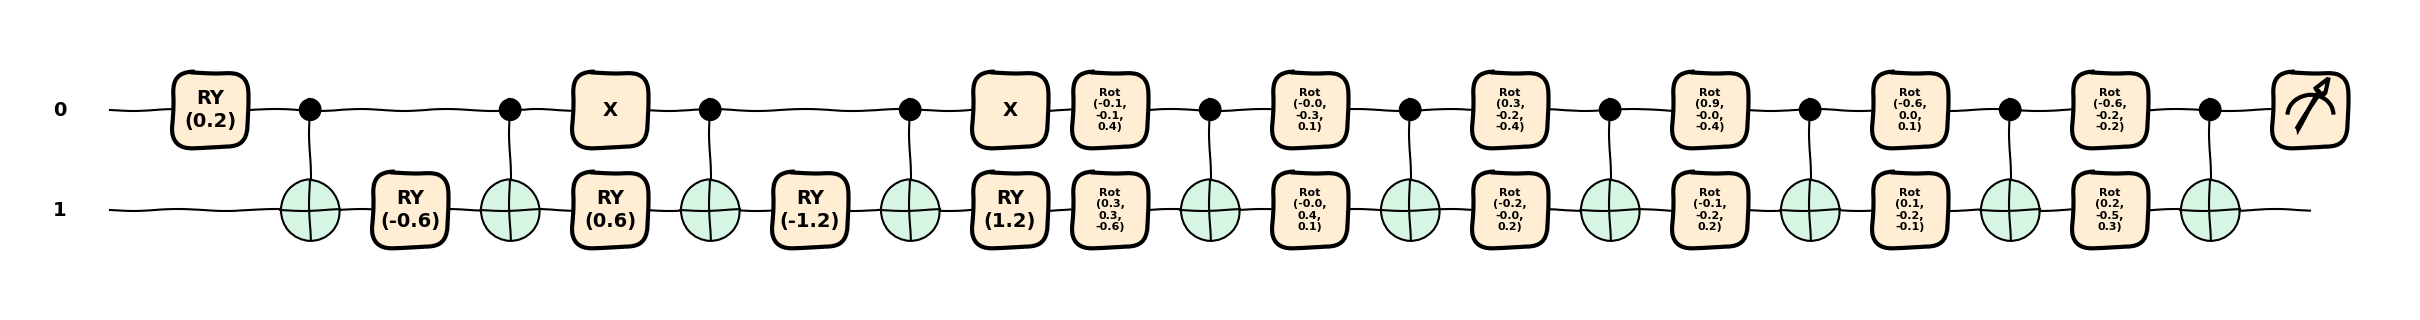

In [45]:
test_angles = [0.23879026, -0.55107359,  0.55107359, -1.22918084,  1.22918084]
print(test_angles)
qnode = qml.QNode(circuit, dev)
qml.draw_mpl(qnode, decimals=1,style="sketch")(random_weights, test_angles)

## Optimization functions

In [46]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [47]:
def accuracy(labels, predictions):
    correct = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            correct = correct + 1
    correct = correct / len(labels)

    return correct

Calculates loss function value

In [48]:
def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

## Preparing data
Extracting data and classes

In [49]:
iris = datasets.load_iris(as_frame=True)
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['class'] = iris.target
le = preprocessing.LabelEncoder()
le.fit(df["class"])
df["class"]=le.transform(df["class"])
le.fit(df["class"])
df["class"]=le.transform(df["class"])

min_max_scaler = preprocessing.MinMaxScaler()
df[["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]] = min_max_scaler.fit_transform(df[["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]])

Use pad vectors and normalize data

In [50]:
X = df.to_numpy()[:, 0:4]
print("First X sample (original)  :", X[0])
X_pad = X

normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = df.to_numpy()[:, -1]

First X sample (original)  : [0.22222222 0.625      0.06779661 0.04166667]
First X sample (normalized): [0.33262469 0.93550694 0.10147872 0.06236713]
First features sample      : [ 0.23879026 -0.55107359  0.55107359 -1.22918084  1.22918084]


Preparing model params

In [51]:
np.random.seed(0)
num_qubits = NUM_QUBITS
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]
num_layers = 6
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

Train model

In [52]:
weights = weights_init
bias = bias_init
for it in range(40):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.rint(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.rint(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 2.4746603 | Acc train: 0.0089286 | Acc validation: 0.0000000 
Iter:     2 | Cost: 1.9435049 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:     3 | Cost: 1.2915000 | Acc train: 0.1696429 | Acc validation: 0.2105263 
Iter:     4 | Cost: 0.8121349 | Acc train: 0.3035714 | Acc validation: 0.3684211 
Iter:     5 | Cost: 0.5018559 | Acc train: 0.3214286 | Acc validation: 0.3947368 
Iter:     6 | Cost: 0.3368322 | Acc train: 0.4553571 | Acc validation: 0.5263158 
Iter:     7 | Cost: 0.2611440 | Acc train: 0.5625000 | Acc validation: 0.6842105 
Iter:     8 | Cost: 0.2480604 | Acc train: 0.6250000 | Acc validation: 0.6842105 
Iter:     9 | Cost: 0.2723552 | Acc train: 0.6517857 | Acc validation: 0.6842105 
Iter:    10 | Cost: 0.2991636 | Acc train: 0.6517857 | Acc validation: 0.6842105 
Iter:    11 | Cost: 0.3072299 | Acc train: 0.6517857 | Acc validation: 0.6842105 
Iter:    12 | Cost: 0.3189405 | Acc train: 0.6607143 | Acc validation: 0.6842105 
Iter:    13 | Co